This notebook loads raw 2D scanning XRD detector data from an HDF5 file, reshapes it into a real-space scan grid, and prepares it for machine-learning-based denoising while preserving absolute intensity information.

The processing pipeline:

Loads raw detector frames as NumPy arrays (full chunk read for robust I/O).

Crops the detector images to a 512×512 region of interest.

Masks invalid detector pixels (sentinel value 2³²−1).

Applies a Poisson-aware variance-stabilizing transform (square-root) to reduce shot noise.

Scales all frames using a single global factor, ensuring relative and absolute intensity differences across scan positions are preserved.

Optionally clips extreme values for numerical stability in ML training.

Computes real-space maps (sum over detector pixels) and reciprocal-space maps (sum over scan positions).

Provides an interactive visualization linking real-space scan positions to their corresponding detector images, showing raw and processed data side-by-side with a selection box.

This workflow ensures the data remain physically interpretable while being well-conditioned for machine-learning denoising and analysis.


**Why we need to preprocess teh data?**

Raw scanning XRD detector images are dominated by Poisson (shot) noise, contain invalid detector pixels, and span a very large dynamic range. Masking bad pixels prevents non-physical values from corrupting the data, while cropping focuses the analysis on the relevant detector region. A variance-stabilizing transform (square-root) reduces shot noise without distorting peak structure, and global scaling preserves absolute intensity differences across the scan. These steps produce numerically stable, physically meaningful inputs that are suitable for machine-learning denoising while retaining real-space and reciprocal-space interpretability.

#### Imports

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import h5py
import hdf5plugin
from tqdm.notebook import tqdm
from scipy.ndimage import median_filter


Load RAW data

In [2]:
data_path = "data/000278.h5"

datah5 = h5py.File(data_path, 'r')
frames = datah5['entry/measurement/eiger500k/frames'][:]   # FULL LOAD (robust)
scan = datah5['entry/description'][:]
datah5.close()

print("Frames:", frames.shape, frames.dtype)
print("Scan info:", scan)


Frames: (17061, 512, 1028) uint32
Scan info: [b'npointflyscan sx 0.5 6.5 120 sy -2 5 140 0.1']


In [3]:
frames.shape == (17061, 512, 1028)


True

Reshape into scan grid

In [4]:
ny, nx = 141, 121
N = ny * nx

frames = frames[:N]   # safety
frames = frames.reshape(ny, nx, 512, 1028)

print("Reshaped:", frames.shape)


Reshaped: (141, 121, 512, 1028)


Define processing steps

In [5]:
BAD = np.uint32(2**32 - 1)

CROP_H, CROP_W = 512, 512   # LEFT crop
USE_SQRT = True            # Poisson shot-noise friendly
CLIP_MAX = 3.0             # optional, can set None


Helper functions

In [6]:
def crop_left(img):
    return img[:, :CROP_W]

def mask_bad(img):
    out = img.astype(np.float32)
    out[out == BAD] = 0.0
    return out

def shot_noise_transform(img):
    if USE_SQRT:
        return np.sqrt(img + 0.375)   # Anscombe-like
    else:
        return np.log1p(img)


Compute GLOBAL SCALE (absolute intensity preserved)

In [7]:
sample_idx = np.linspace(0, N-1, 200, dtype=int)

highs = []
for k in sample_idx:
    iy, ix = divmod(k, nx)
    img = crop_left(frames[iy, ix])
    img = mask_bad(img)
    img = shot_noise_transform(img)
    highs.append(np.percentile(img, 99.9))

GLOBAL_SCALE = float(np.median(highs))
print("GLOBAL_SCALE =", GLOBAL_SCALE)


GLOBAL_SCALE = 1.541103482246399


Apply FULL processing to all frames : **Mian data processing code**

In [8]:
processed = np.empty((ny, nx, CROP_H, CROP_W), dtype=np.float32)

for iy in tqdm(range(ny), desc="Processing rows"):
    for ix in range(nx):
        img = crop_left(frames[iy, ix])      # s0
        img = mask_bad(img)                  # s1
        img = shot_noise_transform(img)      # s2
        img = img / GLOBAL_SCALE             # s3 (absolute preserved)

        if CLIP_MAX is not None:
            img = np.clip(img, 0.0, CLIP_MAX)

        processed[iy, ix] = img



Processing rows:   0%|          | 0/141 [00:00<?, ?it/s]

VISUALIZE: what each step does to ONE detector image

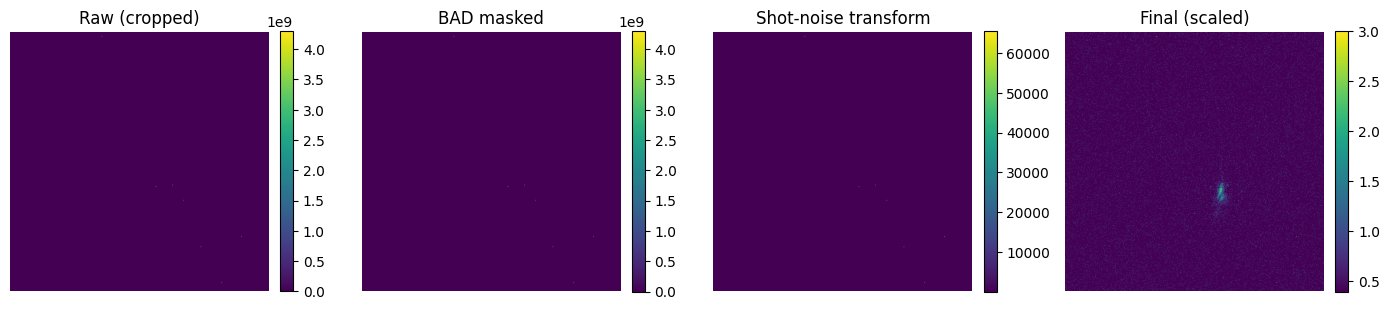

In [19]:
# plotting without vmax
iy, ix = 50, 30

raw = crop_left(frames[iy, ix])
masked = mask_bad(raw)
trans = shot_noise_transform(masked)
final = processed[iy, ix]

plt.figure(figsize=(14,4))
for i, (img, title) in enumerate([
    (raw, "Raw (cropped)"),
    (masked, "BAD masked"),
    (trans, "Shot-noise transform"),
    (final, "Final (scaled)")
]):
    plt.subplot(1,4,i+1)
    #vmax = np.percentile(img, 99.)
    plt.imshow(img, )
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

plt.tight_layout()
plt.show()

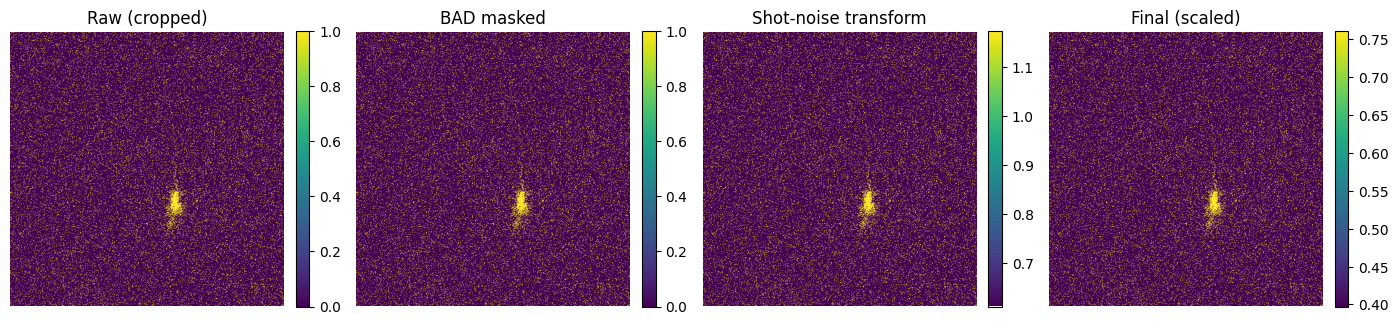

In [ ]:
 # Plotting with vmax
iy, ix = 50, 30

raw = crop_left(frames[iy, ix])
masked = mask_bad(raw)
trans = shot_noise_transform(masked)
final = processed[iy, ix]

plt.figure(figsize=(14,4))
for i, (img, title) in enumerate([
    (raw, "Raw (cropped)"),
    (masked, "BAD masked"),
    (trans, "Shot-noise transform"),
    (final, "Final (scaled)")
]):
    plt.subplot(1,4,i+1)
    vmax = np.percentile(img, 99.0)
    plt.imshow(img, vmax=vmax)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.axis("off")

plt.tight_layout()
plt.show()


Save the data

In [64]:
import h5py
import numpy as np

OUT_PATH = "data/000278_ml_processed_v1.1.h5"

# processed: (ny, nx, 512, 512) float32 / float16
ny, nx, H, W = processed.shape

with h5py.File(OUT_PATH, "w") as f:
    dset = f.create_dataset(
        "data",
        data=processed.astype(np.float16),   # float16 saves space
        compression="gzip",
        compression_opts=4,
        shuffle=True
    )

    # ---- minimal metadata ----
    meta = f.create_group("meta")
    meta.attrs["description"] = (
        "Processed 2D scanning XRD data: "
        "left 512x512 crop, BAD pixels masked, "
        "sqrt variance-stabilizing transform, "
        "global scaling (absolute intensity preserved)."
    )
    meta.attrs["ny"] = ny
    meta.attrs["nx"] = nx
    meta.attrs["height"] = H
    meta.attrs["width"] = W
    meta.attrs["dtype"] = "float16"
    meta.attrs["bad_value"] = int(2**32 - 1)

print("Saved processed data to:", OUT_PATH)




Saved processed data to: data/000278_ml_processed_v1.1.h5


In [ ]:
## To import data from the saved file
#with h5py.File("data/000278_ml_processed.h5", "r") as f:
#    processed = f["data"][:]

#processed = processed.reshape(ny, nx, 512, 512)

VISUALIZE: effect on RealSpace & Reciprocal-space map (detector space)

In [41]:
total_Real_raw = np.sum(frames[:, :, :, :512], axis=(2, 3))
total_RSM_raw  = np.sum(frames[:, :, :, :512], axis=(0, 1))


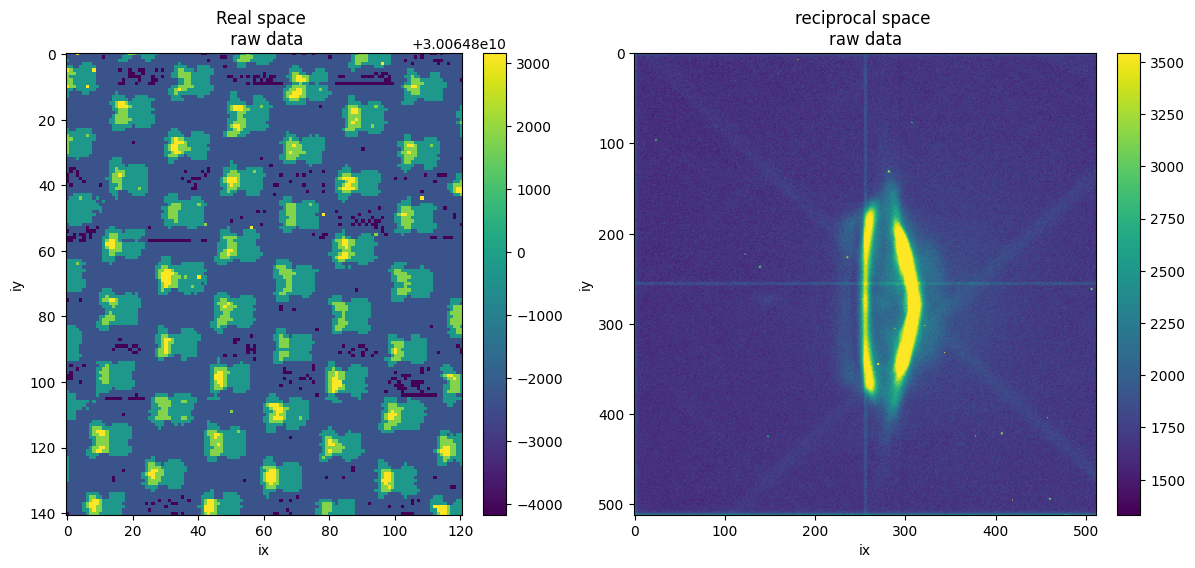

In [55]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(total_Real_raw,vmax=np.percentile(total_Real_raw, 99.0))
plt.title("Real space \n raw data")
plt.xlabel("ix")
plt.ylabel("iy")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(total_RSM_raw,vmax=np.percentile(total_RSM_raw, 99.0))
plt.title("reciprocal space \nraw data")
plt.xlabel("ix")
plt.ylabel("iy")
plt.colorbar(fraction=0.046, pad=0.04)


plt.show()

In [22]:
total_Real_processed = np.sum(processed, axis=(2,3))
total_RSM_processed = np.sum(processed, axis=(0,1))

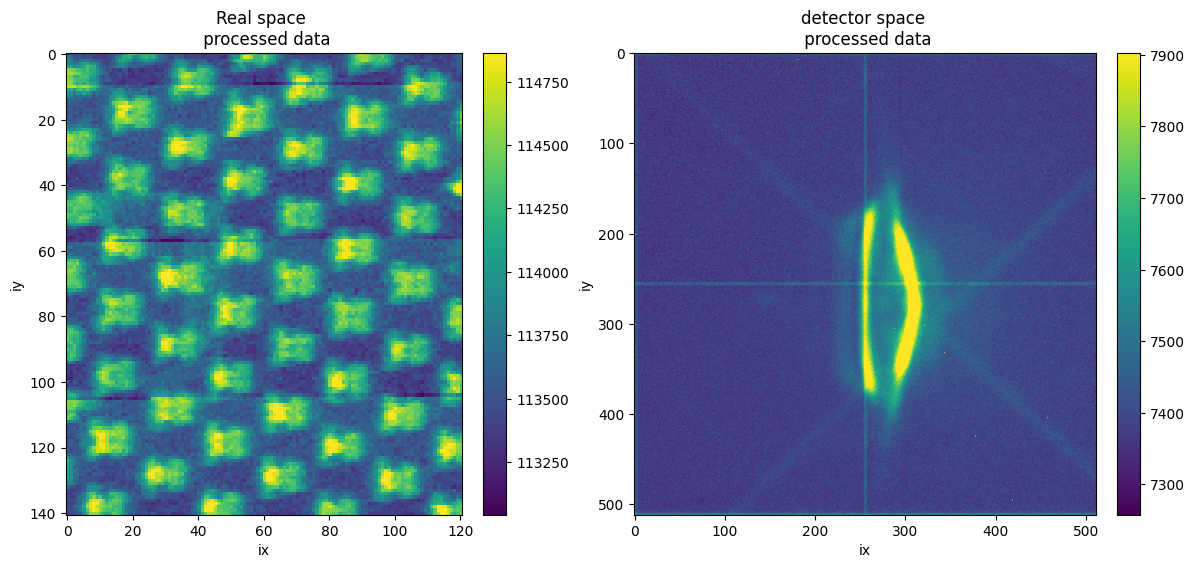

In [56]:
plt.figure(figsize=(15,6))
plt.subplot(1,2,1)
plt.imshow(total_Real_processed,vmax=np.percentile(total_Real_processed, 99.0))
plt.title("Real space \n processed data")
plt.xlabel("ix")
plt.ylabel("iy")
plt.colorbar(fraction=0.046, pad=0.04)

plt.subplot(1,2,2)
plt.imshow(total_RSM_processed,vmax=np.percentile(total_RSM_processed, 99.0))
plt.title("detector space \n processed data")
plt.xlabel("ix")
plt.ylabel("iy")
plt.colorbar(fraction=0.046, pad=0.04)


plt.show()

#### Interactive viewer

In [57]:
import matplotlib.pyplot as plt
import ipywidgets as widgets
from IPython.display import display
from matplotlib.patches import Rectangle

In [63]:
# --- sliders ---
sx = widgets.IntSlider(value=0, min=0, max=nx-1, step=1, description="x (ix)")
sy = widgets.IntSlider(value=0, min=0, max=ny-1, step=1, description="y (iy)")
out = widgets.Output()

def update(iy, ix):
    with out:
        out.clear_output(wait=True)

        # ----- raw + processed frames -----
        raw_crop = crop_left(frames[iy, ix])                 # uint32 (512,512)
        raw_crop_masked = mask_bad(raw_crop)                # float32 (BAD->0)
        proc = processed[iy, ix].astype(np.float32)          # float32

        fig, (axL, axM, axR) = plt.subplots(1, 3, figsize=(16, 5), constrained_layout=True)

        # ===== Left: Real space (processed sum) =====
        imL = axL.imshow(total_Real_processed, origin="upper")
        axL.set_title("Real space (sum over detector) — processed")
        axL.set_xlabel("ix")
        axL.set_ylabel("iy")
        plt.colorbar(imL, ax=axL, fraction=0.046, pad=0.04)

        # Red selection box
        half = box_size // 2
        x0 = max(ix - half, 0)
        y0 = max(iy - half, 0)
        w = min(box_size, nx - x0)
        h = min(box_size, ny - y0)
        axL.add_patch(Rectangle((x0 - 0.5, y0 - 0.5), w, h,
                                fill=False, edgecolor="red", linewidth=2))

        # ===== Middle: RAW detector (cropped, BAD masked) =====
        vmax_raw = np.percentile(raw_crop_masked, 99.0) if np.any(raw_crop_masked) else 1.0
        imM = axM.imshow(raw_crop_masked, origin="upper", vmax=vmax_raw)
        axM.set_title(f"RAW detector (cropped, BAD→0)\n(y={iy}, x={ix})")
        axM.set_xlabel("qx")
        axM.set_ylabel("qy")
        plt.colorbar(imM, ax=axM, fraction=0.046, pad=0.04)

        # ===== Right: FINAL processed detector =====
        vmax_proc = np.percentile(proc, 99.0) if np.any(proc) else 1.0
        imR = axR.imshow(proc, origin="upper", vmax=vmax_proc)
        axR.set_title("FINAL processed detector")
        axR.set_xlabel("qx")
        axR.set_ylabel("qy")
        plt.colorbar(imR, ax=axR, fraction=0.046, pad=0.04)

        plt.show()

ui = widgets.HBox([sy, sx])
display(ui)
display(out)

widgets.interactive_output(update, {"iy": sy, "ix": sx})
update(sy.value, sx.value)

Output()